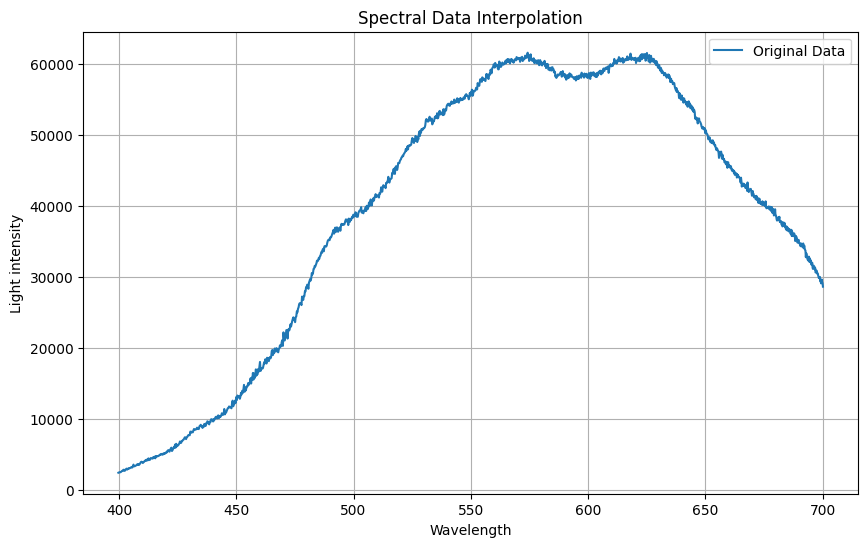

In [173]:
#Code to get the spectral energy function using Raw Data #1 and dark columns. I think create a linear interpolation and that is my function to find
#Spectral energy at any given wavelength

import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

def read_complex_file(file_path, encoding='utf-8'):
    with open(file_path, 'r', encoding=encoding) as file:
        lines = file.readlines()

    data_start = next(i for i, line in enumerate(lines) if line.startswith("Pixel;Wavelength;"))
    columns = lines[data_start].strip().split(';')
    data = [line.strip().split(';') for line in lines[data_start+1:]]

    df = pd.DataFrame(data, columns=columns)

    numeric_columns = ['Wavelength', 'Raw data #1']
    for col in numeric_columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    return df

def spectral_energy(df):
    required_columns = ["Wavelength", "Raw data #1"]
    if all(col in df.columns for col in required_columns) and not df[required_columns].isna().all().any():
        #Dropping any rows that NaN as their values
        df_clean = df.dropna(subset=required_columns)

        wavelengths = df_clean["Wavelength"].to_numpy()
        raw_data_01 = df_clean["Raw data #1"].to_numpy()
        dark = df_clean["Dark"].to_numpy()

        dark = dark.astype(float)
        light_intensity = raw_data_01 - dark

        # Create the interpolation function
        interp = interp1d(wavelengths, light_intensity, kind='linear', fill_value='extrapolate')

        plt.figure(figsize=(10, 6))
        plt.plot(wavelengths, light_intensity, label='Original Data')
        plt.xlabel('Wavelength')
        plt.ylabel('Light intensity')
        plt.title('Spectral Data Interpolation')
        plt.legend()
        plt.grid(True)
        plt.show()

        return interp, wavelengths, light_intensity
    else:
        print(f"Error: Missing one or more required columns or all values are NaN. Expected: {required_columns}")
        print(f"Found: {df.columns.tolist()}")


# Read the file
file_path = '0000.txt'
df = read_complex_file(file_path)
spectral_energy_function, wavelength_array, light_intensity = spectral_energy(df)

In [91]:
def cone_one_curves(wavelength):
  return np.exp(-((wavelength - 447)**2) / (2 * 55**2))

def cone_two_curves(wavelength):
  return np.exp(-((wavelength - 554)**2) / (2 * 55**2))

def combined_curve_function(wavelength):
  return cone_one_curves(wavelength) + cone_two_curves(wavelength)

In [194]:
#Finding response_1 and response_2 through both integration and summation method

import numpy as np

def calc_final_val(spectral_energy, wavelength):
  response_1 = np.trapz(cone_one_curves(wavelength) * spectral_energy_function(wavelength), wavelength)
  response_2 = np.trapz(cone_two_curves(wavelength) * spectral_energy_function(wavelength), wavelength)
  return response_1, response_2

def calc_final_sum(spectral_energy, wavelength):
  delta_wavelength = wavelength[1] - wavelength[0]
  response_1_sum = np.sum(cone_one_curves(wavelength) * spectral_energy_function(wavelength) * delta_wavelength)
  response_2_sum = np.sum(cone_two_curves(wavelength) * spectral_energy_function(wavelength) * delta_wavelength)
  return response_1_sum, response_2_sum

print(calc_final_val(spectral_energy, wavelength_array))
print(calc_final_sum(spectral_energy, wavelength_array))

(2482985.33573671, 6817258.039122377)
(2803048.592612968, 8561127.301935488)


In [200]:
#Finding cone_vector1 and cone_vector_2 for both cone wavelengths
cone_vector_1 = [cone_one_curves(wavelength_array[i]) for i in range(len(wavelength_array))]
cone_vector_2 = [cone_two_curves(wavelength_array[i]) for i in range(len(wavelength_array))]
print(cone_vector_1[:5])
print(cone_vector_2[:5])

[0.6914125534857681, 0.6943262769519225, 0.6972354763151714, 0.7001399921090403, 0.7030396645401449]
[0.019589969512496613, 0.01986130556121308, 0.020135914556816892, 0.020413828425117044, 0.020695079292369557]


In [202]:
#Finding pixel_vector
pixel_vector = [spectral_energy_function(wavelength_array[i]) for i in range(len(light_intensity))]
print(pixel_vector[:10])

[array(2438.), array(2473.), array(2525.), array(2492.), array(2545.), array(2616.), array(2703.), array(2677.), array(2850.), array(2850.)]


In [196]:
#Finding respone_1 and response_2 by taking the dot product of cone_vector_1 and pixel_vector, and cone_vector_2 and pixel_vector
response_1 = np.dot(cone_vector_1, pixel_vector)
response_2 = np.dot(cone_vector_2, pixel_vector)

In [191]:
#Normalizing the vectors
def normalize_vector(v):
    norm = np.linalg.norm(v)
    if norm == 0:
        return v
    return v / norm

cone_vector_1_normalized = normalize_vector(cone_vector_1)
cone_vector_2_normalized = normalize_vector(cone_vector_2)
pixel_vector_normalized = normalize_vector(pixel_vector)

In [197]:
#Finding min_vec_1 and min_vec_2 by using the np.linalg.lstsq function
cone_1_vector_reshaped = np.array(cone_vector_1).reshape(-1, 1)
cone_2_vector_reshaped = np.array(cone_vector_2).reshape(-1, 1)

response_1_arr = np.full((cone_1_vector_reshaped.shape[0], 1), response_1)
response_2_arr = np.full((cone_1_vector_reshaped.shape[0], 1), response_2)

min_vec_1, _, _, _ = np.linalg.lstsq(cone_1_vector_reshaped, response_1_arr, rcond=None)
min_vec_2, _, _, _ = np.linalg.lstsq(cone_2_vector_reshaped, response_2_arr, rcond=None)

(3088, 2056)


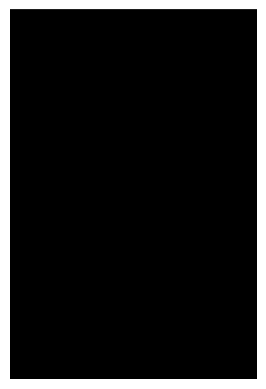

In [198]:
#Projecting the min_vec_1 and min_vec_2 onto the standard RGB response curves to get an RGB with how a cat looks at the image
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import interp2d

def interpolate_data(data, new_shape):
    old_x = np.linspace(0, 1, len(data))
    new_x = np.linspace(0, 1, new_shape[0] * new_shape[1])

    interpolator = interp1d(old_x, data, kind='linear', fill_value='extrapolate')
    interpolated = interpolator(new_x)

    # Reshape the interpolated data to the new shape
    return interpolated.reshape(new_shape)

def cat_data_to_image(min_vec_1, min_vec_2, light_sensitivity, cone_vector_1, cone_vector_2, rgb_sensitivities):
    image = Image.open("seattle001_2.tiff")
    print(image.size)
    height = image.size[0]
    width = image.size[1]

    human_viewable = np.zeros((height, width, 3))

    cone_responses_1 = interpolate_data(np.array(cone_vector_1), (height, width))
    cone_responses_2 = interpolate_data(np.array(cone_vector_2), (height, width))

    light_sensitivity = light_sensitivity.reshape(-1, 1)

    for i in range(height):
      for j in range(width):
        # spectral_energy = spectral_energy_function(wavelength_array[i*width + j])

        cat_response_1 = cone_responses_1[i, j] * min_vec_1[0][0]
        cat_response_2 = cone_responses_2[j, j] * min_vec_2[0][0]

        cat_response = cat_response_1 + cat_response_2

        rgb_values = np.sum(cat_response * light_sensitivity * rgb_sensitivities)
        # Normalize RGB values
        rgb_values = np.clip(rgb_values / np.max(rgb_values), 0, 1)

        human_viewable[i, j] = rgb_values

      return human_viewable


rgb_sensitivities = np.array([
    np.exp(-((wavelength_array - 430)**2) / (2 * 50**2)),
    np.exp(-((wavelength_array - 530)**2) / (2 * 50**2)),
    np.exp(-((wavelength_array - 620)**2) / (2 * 50**2))
]).T

converted_image = cat_data_to_image(min_vec_1, min_vec_2, light_intensity, cone_vector_1_normalized, cone_vector_1_normalized, rgb_sensitivities)

plt.imshow(converted_image)
plt.axis('off')
plt.show()

In [ ]:
#Other approach

min_vec_arr = []

rgb_sensitivities = np.array([
    np.exp(-((wavelength_array - 430)**2) / (2 * 50**2)),
    np.exp(-((wavelength_array - 530)**2) / (2 * 50**2)),
    np.exp(-((wavelength_array - 620)**2) / (2 * 50**2))
])

for i in range(len(wavelength_array)):
  cone_vector_1_normalized = normalize_vector(cone_one_curves(wavelength_array[i]))
  cone_vector_2_normalized = normalize_vector(cone_two_curves(wavelength_array[i]))
  pixel_vector_normalized = normalize_vector(spectral_energy_function(wavelength_array[i]))

  response_1 = np.dot(cone_vector_1_normalized, pixel_vector_normalized)
  response_2 = np.dot(cone_vector_2_normalized, pixel_vector_normalized)

  min_vec_1, min_vec_2 = min_vec_finder(cone_vector_1_normalized, cone_vector_2_normalized)
  min_vec_arr.append([min_vec_1, min_vec_2])


